# Didactic Exploration of Multi-Task vs. Single-Task Learning on CIFAR-10

## 1. Introduction

In deep learning, we often train models to perform a single, specific task, this is **Single-Task Learning (STL)**. However, many real-world problems benefit from learning multiple related tasks simultaneously. This approach, known as **Multi-Task Learning (MTL)**, aims to improve a model's generalization capabilities and learning efficiency by leveraging shared knowledge across tasks. The underlying hypothesis is that learning related tasks together can act as a form of **inductive transfer** or regularization, leading to more robust representations.

This notebook provides a hands-on, didactic comparison between STL and different MTL strategies. We will use the **CIFAR-10** dataset as our foundation and build models based on the classic **AlexNet** architecture. Our goal is not necessarily to achieve state-of-the-art results, but rather to understand the *mechanisms* and *behaviors* of these learning paradigms.

### 1.1. Chosen Tasks

We define two distinct tasks using the CIFAR-10 dataset:

1.  **Task 1 (T1): Multi-class Object Classification**: The standard CIFAR-10 challenge: classifying an image into one of its 10 categories (e.g., airplane, dog, cat). This is our primary task.
2.  **Task 2 (T2): Rotation Classification**: A custom task – determining if an input image has been rotated by 0°, 90°, 180°, or 270°. This task focuses more on orientation and low-level features.

We *intentionally* chose these tasks because they are uncorrelated. Will learning about image orientation help in classifying objects, or will it interfere?

### 1.2. Learning Approaches

We will implement and compare three distinct learning approaches:

1.  **Single-Task Learning (STL)**: Our baseline. We train two *completely independent* AlexNet models, one for each task.
2.  **Hard Parameter Sharing MTL**:  We use *one* AlexNet model with a shared backbone and two *separate* classification heads. This forces tasks to share the same underlying representation.
3.  **Soft Parameter Sharing MTL (Cross-Stitch Networks)**: A more flexible approach. We use *two* AlexNet models but insert "Cross-Stitch" units between certain layers. These units *learn* how to linearly combine features from both networks, allowing for an adaptive, 'soft' sharing of information.

### 1.3. Learning Objectives

By working through this notebook, we will:

1. Understand the core concepts of Multi-Task Learning and how it differs from Single-Task Learning.
2. Explore the benefits and challenges of Hard and Soft parameter sharing in MTL.
3. Analyze the performance of STL vs. MTL approaches on CIFAR-10.

In [2]:
# ===================================================================
# Setup: Import Libraries and Configure the Environment
# ===================================================================
# Here, we import all necessary libraries and configure our setup,
# including setting up PyTorch to use a GPU if available and ensuring
# reproducibility through random seeds.
# ===================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
from PIL import Image


# -------------------------------------------
# Configuration and Reproducibility
# -------------------------------------------

# Set a random seed for PyTorch, NumPy, and Python's random module.
# This helps in making our experiments reproducible. While deep learning
# training can have inherent randomness (especially on GPUs), setting
# seeds makes it *more* likely to get similar results across runs.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------------------------
# Device Configuration (GPU vs. CPU)
# -------------------------------------------

# We check if a CUDA-enabled GPU is available. If so, we set our 'device'
# to 'cuda'; otherwise, we use the 'cpu'. Training deep learning models
# is significantly faster on GPUs. The .to(device) method will be used
# later to move our models and data to the chosen device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------
# Hyperparameters and Constants
# -------------------------------------------

# Define key hyperparameters for our training process.
BATCH_SIZE = 128   # How many samples per batch to load.
NUM_EPOCHS = 50   # Number of complete passes through the training dataset.
LEARNING_RATE = 1e-3 # Controls how much we adjust model weights during training.
NUM_CLASSES_T1 = 10 # CIFAR-10 has 10 classes (Task 1).
NUM_CLASSES_T2 = 4  # Rotation task has 4 classes (0, 90, 180, 270 degrees).

# --- Mixed Precision Setup ---
use_amp = device.type == 'cuda'
scaler = torch.amp.GradScaler(device, enabled=use_amp)


Using device: cuda


## 2. Data Preparation: CIFAR-10 Dataset

We need to load the CIFAR-10 dataset and prepare it for our two distinct tasks. This involves creating a custom PyTorch `Dataset` that can serve data for both tasks simultaneously.

In PyTorch, the creation of custom datasets is easy. This is primarily accomplished by **extending the base `torch.utils.data.Dataset` class**. The core requirement is to override two essential methods:
* `__len__(self)`: This method should return the total number of samples in the dataset.
* `__getitem__(self, idx)`: This method is responsible for loading and returning a single sample from the dataset given an index `idx`.

In PyTorch, typically, **class labels are represented as integer indices** (zero-based). This integer representation is the standard expectation for many of PyTorch's loss functions, such as `torch.nn.CrossEntropyLoss`. The standard CIFAR-10 dataset provides class labels in this format, where each class is represented by an integer from 0 to 9. Indeed, for the new task we will also use integer labels (0 for 0° rotation, 1 for 90°, etc.). This consistency allows us to use the standard classification loss functions without any additional conversion steps.

### 2.1. MultiTaskCIFAR10


In [3]:
class MultiTaskCIFAR10(torchvision.datasets.CIFAR10):
    """
    CIFAR-10 expanded for two tasks:
      - Task 1: classify into 10 CIFAR-10 object classes
      - Task 2: classify rotation into 4 angles (0°, 90°, 180°, 270°)

    Each original image is repeated 4 times, once per rotation angle.
    """

    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download,
                         transform=None, target_transform=None)
        self.transform = transform
        # Define the rotation angles
        self.angles = [0, 90, 180, 270]
        # Expanded length = 4 × number of original images
        # Tells PyTorch how many samples the new dataset has (4× more than CIFAR-10).
        self.expanded_len = len(self.data) * len(self.angles)

    def __len__(self):
        # Return the expanded dataset size
        return self.expanded_len

    def __getitem__(self, idx):
        # Picks one of the 50,000 original images.
        angle_idx = idx % 4
        # Picks one of the four rotations.
        orig_idx  = idx // 4

        # Load the original image as a PIL.Image
        img = Image.fromarray(self.data[orig_idx])

        # Get the original CIFAR-10 class label (0–9)
        class_label = self.targets[orig_idx]

        # Rotate the image without changing its size (32×32)
        angle = self.angles[angle_idx]
        img = img.rotate(angle, expand=False)

        # Apply any final transforms (ToTensor, Normalize, etc.)
        if self.transform is not None:
            img = self.transform(img)

        # Rotation label is simply angle_idx (0..3)
        rotation_label = angle_idx

        # Return (image, class_label, rotation_label)
        return img, class_label, rotation_label

In [4]:
# -------------------------------------------
# Create Dataset Instances
# -------------------------------------------
# We create instances of our custom dataset for both training and validation.
train_dataset = MultiTaskCIFAR10(root='./data/', train=True, download=True)
test_dataset = MultiTaskCIFAR10(root='./data/', train=False, download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:09<00:00, 17.3MB/s] 


Number of training samples: 200000
Number of test samples: 40000


In [5]:
mean = train_dataset.data.mean(axis=(0, 1, 2))/255
std = train_dataset.data.std(axis=(0, 1, 2))/255

print(f'Mean: {mean}, Std.:{std}')

Mean: [0.49139968 0.48215841 0.44653091], Std.:[0.24703223 0.24348513 0.26158784]


**Note**: `ToTensor()` converts a PIL image or NumPy array into a float `torch.Tensor` with channels-first ordering and scales pixel values to [0, 1]. We then use `Normalize()` to adjust these tensor values based on the dataset's mean and standard deviation. This entire transformation process makes the data compatible with PyTorch models and helps optimize training.

In [6]:
# Define the transformation pipeline including ToTensor and Normalize
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),  # Converts image to Tensor and scales to [0, 1]
    transforms.Normalize(
        mean=mean,  # CIFAR-10 Mean
        std=std    # CIFAR-10 Std. Dev.
    )
])

**Important Note:** The mean and standard deviation values used for `Normalize` must **always** be calculated using **only the training dataset**. This is crucial to prevent *data leakage* – where information from the test or validation sets inadvertently influences the training process – and ensures a fair and realistic evaluation of the model's performance on unseen data.

In [7]:
# -------------------------------------------
# Create Dataset Instances
# -------------------------------------------
# We create instances of our custom dataset for both training and validation.
train_dataset = MultiTaskCIFAR10(root='./data/', train=True, transform=transform_pipeline, download=True)
test_dataset = MultiTaskCIFAR10(root='./data/', train=False, transform=transform_pipeline, download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of tes samples: {len(test_dataset)}")

# -------------------------------------------
# Create DataLoaders
# -------------------------------------------
# DataLoaders are PyTorch utilities that provide an iterable over a dataset.
# They handle batching, shuffling, and can use multiple worker processes
# to load data in parallel, which is crucial for efficient GPU utilization.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffling the data is important for training to prevent model bias and improve generalization.
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle the validation/test set.
)

Number of training samples: 200000
Number of tes samples: 40000


### 2.2 Validation Set
We will use a 10% of our training dataset as a validation set. This set will be used to evaluate the model's performance during training, allowing us to monitor for overfitting.


In [8]:
# 90% for training, 10% for validation
val_size   = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split with a fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

### 2.3 Visualize a Sample Batch
Before moving on, let's visualize a sample batch from our dataset to ensure everything is set up correctly. This will help us confirm that our custom dataset works as expected and that the images are correctly transformed and labeled for both tasks.




Visualize a sample batch...


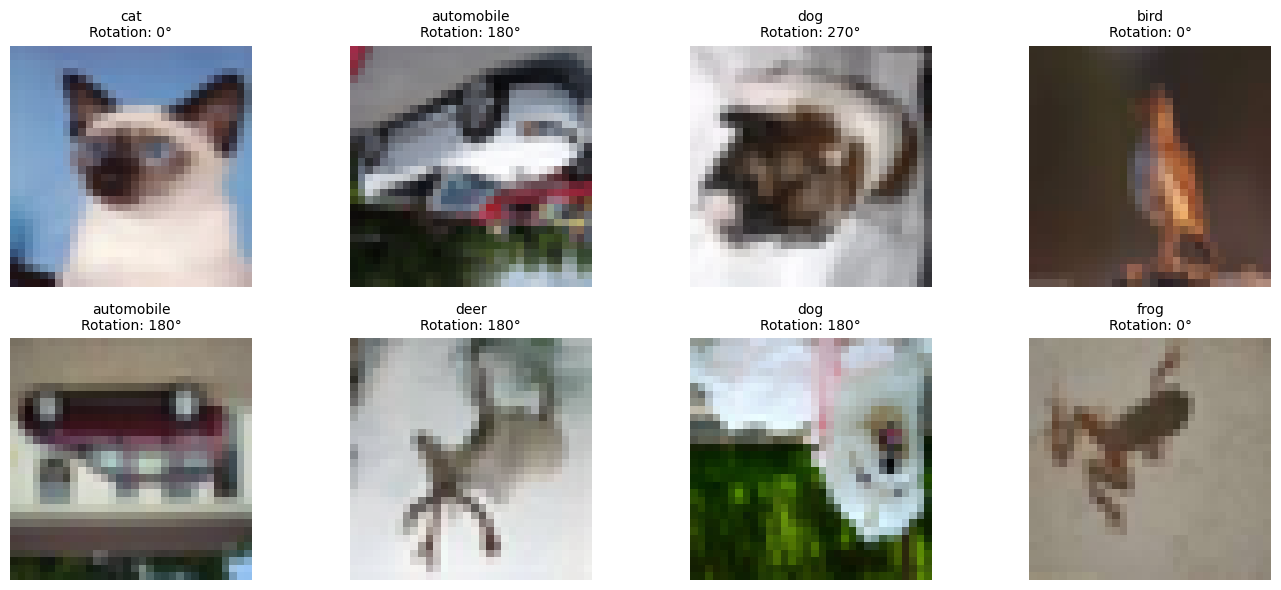

In [9]:
# -------------------------------------------
# Visualize a Sample Batch
# -------------------------------------------
# We visualize a few samples to ensure
# the data loading and transformations are working as expected.

def imshow(img):
    """Helper function to display an image."""
    npimg = img.numpy() # Covert the image to Numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from [C, H, W] to [H, W, C]
    plt.axis('off')

print("\nVisualize a sample batch...")

# Get one batch of training images.
dataiter = iter(train_loader)
images, labels_t1, labels_t2 = next(dataiter)

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Task 2 labesl
rotation_labels = ['0°', '90°', '180°', '270°']


def imshow_denorm(img, mean, std):
    """Helper function to de-normalize and display an image."""

    # Ensure std and mean are in [C, 1, 1] shape for broadcasting
    std = torch.tensor(std).view(3, 1, 1)
    mean = torch.tensor(mean).view(3, 1, 1)

    # De-normalize: img * std + mean
    img = img * std + mean

    # Clip to [0, 1] to handle potential floating point inaccuracies
    # and ensure it's a valid range for imshow
    img = torch.clamp(img, 0, 1)

    # Convert to NumPy and transpose
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # from [C, H, W] to [H, W, C]
    plt.axis('off')


# Plot each image in a 2x4 grid with corresponding labels
# We will show just 8 samples
plt.figure(figsize=(14, 6))
for idx in range(len(images[:8])):
    plt.subplot(2, 4, idx+1)
    imshow_denorm(images[idx], mean, std)
    title = f"{class_names[labels_t1[idx]]}\nRotation: {rotation_labels[labels_t2[idx]]}"
    plt.title(title, fontsize=10)
plt.tight_layout()
plt.show()

## 3. Architectures
To define the architectures we will use, which are based on **AlexNet**, we need:
1.  A base `AlexNet` class.
2.  A `HardMTL` class implementing hard parameter sharing.
3.  A `CrossStitchUnit` and `CrossStitchNetwork` class for soft parameter sharing.
4.  A `SingleTask` class for single-task learning.


### 3.1. Base AlexNet

In [10]:
class AlexNet(nn.Module):
    """
    Implementation of the AlexNet architecture, adapted for CIFAR-10.
    """
    def __init__(self, num_outputs=10):
        """
        Initializes the AlexNet model.

        Args:
            num_outputs (int): The number of output neurons in the final layer.
                               This will depend on the task (10 for T1, 4 for T2).
        """
        super(AlexNet, self).__init__() # Always call the parent constructor.

        # --- Feature Extractor (Convolutional Layers) ---
        # This part extracts features from the input image.
        self.features = nn.Sequential(
            # Layer 1: Conv -> ReLU -> MaxPool
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # CIFAR-10 is small (32x32), so we adapt AlexNet.
            nn.ReLU(inplace=True), # ReLU (Rectified Linear Unit) is a common activation function. 'inplace=True' saves memory.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max-pooling reduces spatial dimensions, providing some translation invariance.

            # Layer 2: Conv -> ReLU -> MaxPool
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3: Conv -> ReLU
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 4: Conv -> ReLU
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 5: Conv -> ReLU -> MaxPool
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # --- Classifier (Fully-Connected Layers) ---
        # This part takes the extracted features and performs classification.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # Dropout is a regularization technique to prevent overfitting. It randomly sets some activations to 0.
            nn.Linear(256 * 4 * 4, 1024), # Linear (fully-connected) layer. Input size = channels * height * width.
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, num_outputs), # The final output layer, size depends on the task.
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor (batch of images).

        Returns:
            torch.Tensor: The output tensor (logits for each class).
        """
        # Pass through feature extractor.
        x = self.features(x)
        # Flatten the output for the classifier.
        # torch.flatten(x, 1) flattens all dimensions except the batch dimension (dim 0).
        x = torch.flatten(x, 1)
        # Pass through classifier.
        logits = self.classifier(x)
        return logits

### 3.2. Hard Parameter Sharing MTL (`HardMTL`)

This model leverages the PyTorch submodule `features` defined in the base `AlexNet` class, as a shared backbone for both tasks. Then, each task has its own classification head. The forward method processes the input through the shared backbone and then through the respective task-specific heads.

In [11]:
class HardMTL(nn.Module):
    """
    Implements a Hard Parameter Sharing Multi-Task Learning model
    using AlexNet as the base.
    """
    def __init__(self):
        super(HardMTL, self).__init__()
        # --- Shared Feature Extractor ---
        # We take the feature extractor directly from the base AlexNet.
        # These weights will be updated by gradients from BOTH tasks.
        self.features = AlexNet().features

        # --- Task-Specific Classifiers ---
        # We create two separate classifiers, one for each task.
        # We reuse the structure of the AlexNet classifier but adjust the
        # final output layer size for each task.
        self.classifier_t1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T1), # Output for Task 1
        )
        self.classifier_t2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T2), # Output for Task 2
        )

    def forward(self, x):
        """
        Defines the forward pass for the Hard MTL model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            tuple: (output_t1, output_t2)
                   - output_t1: Logits for Task 1.
                   - output_t2: Logits for Task 2.
        """
        # Pass through the shared layers.
        x = self.features(x)

        x = torch.flatten(x, 1)

        # Pass through the task-specific heads.
        logits_t1 = self.classifier_t1(x)
        logits_t2 = self.classifier_t2(x)

        return logits_t1, logits_t2

### 3.3. Soft Parameter Sharing (Cross-Stitch Network)
Cross-Stitch Networks are a deep learning architectures for Multi-Task Learning (MTL). Their main idea is to let separate networks, each working on a different task, choose how to share and mix information at different layers. This happens using **cross-stitch units** that learn to combine features from both networks through linear combinations. This allows the model to adaptively decide how much information to share between tasks, rather than forcing a fixed sharing strategy.

**Note**: Before moving on, we need to redefine the `AlexNet` class already implemented in this notebook in order to correctly place the cross-stitch units when defining the `CrossStitchNetwork` class.

---

We will follow the cross-stitch network architecture described in the following paper: [*Cross-Stitch Networks for Multi-Task Learning*](https://arxiv.org/abs/1604.03539).


In [12]:
class AlexNet_mod(nn.Module):
    def __init__(self, num_outputs=10):
        super(AlexNet_mod, self).__init__()

        # Convolutional Block 1 (Conv1 -> ReLU -> MaxPool1)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 64, 16, 16
        )
        # Convolutional Block 2 (Conv2 -> ReLU -> MaxPool2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 192, 8, 8
        )
        # Convolutional Block 3 (Conv3 -> ReLU -> Conv4 -> ReLU -> Conv5 -> ReLU -> MaxPool3)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 256, 4, 4
        )

        # Classifier Fully-Connected Block 1
        self.fc_block1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Classifier Fully-Connected Block 2
        self.fc_block2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Final Output Layer
        self.output_layer = nn.Linear(1024, num_outputs)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)
        x = self.fc_block1(x)
        x = self.fc_block2(x)
        logits = self.output_layer(x)
        return logits

#### 3.3.1. Cross-Stitch Unit

Cross-Stitch Unit controls the degree of information sharing between tasks. Let's break down how it works in the context of our two-task learning:

- Consider a specific layer, $l$ in the network where we want to apply the Cross-Stitch unit. At this layer, we have two branches: Branch A for Task A and Branch B for Task B. Branch A provides its current feature representation, $x_A^{(l)}$, and Branch B provides its feature representation, $x_B^{(l)}$. The Cross-Stitch unit takes these two inputs and computes new, updated feature representations for each branch: $\tilde{x}_A^{(l)}$ for Branch A and $\tilde{x}_B^{(l)}$ for Branch B. These updated features then proceed to the subsequent layers within their respective branches.

- For two-task learning, the cross-stitch unit is $2 \times 2$ matrix, and it works as follows:

$$
\begin{bmatrix} \tilde{x}_A^{(l)} \\ \tilde{x}_B^{(l)} \end{bmatrix} =
\begin{bmatrix} \alpha_{AA}^{(l)} & \alpha_{AB}^{(l)} \\ \alpha_{BA}^{(l)} & \alpha_{BB}^{(l)} \end{bmatrix}
\begin{bmatrix} x_A^{(l)} \\ x_B^{(l)} \end{bmatrix}
$$

Where:

* **$\alpha_{AA}^{(l)}$ and $\alpha_{BB}^{(l)}$ (Same-Task Weights):** Control how much of the original information from Task A ($x_A^{(l)}$) remains within Branch A, and similarly for Task B ($x_B^{(l)}$) within Branch B.
* **$\alpha_{AB}^{(l)}$ and $\alpha_{BA}^{(l)}$ (Different-Task Weights):** Control the information exchange *between* the two tasks. Specifically, $\alpha_{AB}^{(l)}$ determines how much of Task B's information ($x_B^{(l)}$) is incorporated into Task A's updated features ($\tilde{x}_A^{(l)}$). Conversely, $\alpha_{BA}^{(l)}$ controls how much of Task A's information ($x_A^{(l)}$) influences Task B's updated features ($\tilde{x}_B^{(l)}$).

The $\alpha$ parameters can be fixed or learned during training. In this notebook, we will learn them during training, allowing the model to adaptively determine how much information to share between tasks.

In [13]:
class CrossStitchUnit(nn.Module):
    """
    Implements a Cross-Stitch unit.
    This unit learns a 2x2 matrix (alpha) to linearly combine the
    feature maps from two task-specific networks.
    """
    def __init__(self):
        """
        Initializes the Cross-Stitch unit.
        """
        super(CrossStitchUnit, self).__init__()
        # --- Learnable Alpha Matrix ---
        # nn.Parameter tells PyTorch that this tensor should be considered
        # a model parameter, meaning it should be tracked for gradients
        # and updated during training by the optimizer.
        # We use a 2x2 matrix because we have two tasks.
        # We initialize all values to 0.5
        self.alpha = nn.Parameter(torch.ones(2, 2) * 0.5)

    def forward(self, x1, x2):
        """
        Performs the cross-stitch operation.

        Args:
            x1 (torch.Tensor): Feature map from Task 1's network.
            x2 (torch.Tensor): Feature map from Task 2's network.

        Returns:
            tuple: (out1, out2)
                   - out1: Combined feature map for Task 1.
                   - out2: Combined feature map for Task 2.
        """
        # Apply softmax to the alpha matrix to ensure the weights sum to 1.
        alpha = torch.softmax(self.alpha, dim=1) # Softmax along the rows (dim=1)

        # Perform the cross-stitch operation
        out1 = alpha[0, 0] * x1 + alpha[0, 1] * x2
        out2 = alpha[1, 0] * x1 + alpha[1, 1] * x2
        return out1, out2


#### 3.3.2. CrossStitchNetwork
The architecture of the Cross-Stitch Network we will implement is based on the the following figure, which shows how the cross-stitch units are placed between the layers of the AlexNet architecture.

<div align="center">
  <img src="https://github.com/Gwme13/MTL_with_Pytorch/blob/main/images/AlexNet-Cross-Stitch.PNG?raw=1" alt="Cross-Stitch Network Architecture" width="600">
</div>

---
Misra, I., Shrivastava, A., Gupta, A., & Hebert, M. (2016). *Cross-stitch Networks for Multi-task Learning*. arXiv:1604.03539. [https://arxiv.org/abs/1604.03539](https://arxiv.org/abs/1604.03539)

In [14]:
class CrossStitchNetwork(nn.Module):
    """
    Implements a Cross-Stitch Network using two modified AlexNet backbones,
    with cross-stitch layers applied after every pooling and FC layer.
    """
    def __init__(self):
        super(CrossStitchNetwork, self).__init__()

        self.task1_net = AlexNet_mod(num_outputs=NUM_CLASSES_T1)
        self.task2_net = AlexNet_mod(num_outputs=NUM_CLASSES_T2)

        # --- Cross-Stitch Layers ---
        self.cs_pool1 = CrossStitchUnit()
        self.cs_pool2 = CrossStitchUnit()
        self.cs_pool3 = CrossStitchUnit()

        self.cs_fc1 = CrossStitchUnit()
        self.cs_fc2 = CrossStitchUnit()


    def forward(self, x):
        """
        Defines the forward pass for the Cross-Stitch Network.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            tuple: (out1, out2) - Logits for Task 1 and Task 2.
        """
        # --- Initial Input ---
        # Both networks process the same input initially
        x_t1 = x
        x_t2 = x

        # --- Conv Block 1 (includes Pool1) ---
        x_t1_p1 = self.task1_net.conv_block1(x_t1)
        x_t2_p1 = self.task2_net.conv_block1(x_t2)

        x_t1_p1_cs, x_t2_p1_cs = self.cs_pool1(x_t1_p1, x_t2_p1)

        # --- Conv Block 2 (includes Pool2) ---
        x_t1_p2 = self.task1_net.conv_block2(x_t1_p1_cs)
        x_t2_p2 = self.task2_net.conv_block2(x_t2_p1_cs)

        x_t1_p2_cs, x_t2_p2_cs = self.cs_pool2(x_t1_p2, x_t2_p2)

        # --- Conv Block 3 (includes Pool3) ---
        x_t1_p3 = self.task1_net.conv_block3(x_t1_p2_cs)
        x_t2_p3 = self.task2_net.conv_block3(x_t2_p2_cs)

        x_t1_p3_cs, x_t2_p3_cs = self.cs_pool3(x_t1_p3, x_t2_p3)

        # Flatten for Classifier
        x_t1_flat = torch.flatten(x_t1_p3_cs, 1)
        x_t2_flat = torch.flatten(x_t2_p3_cs, 1)

        # --- FC Block 1 ---
        x_t1_fc1 = self.task1_net.fc_block1(x_t1_flat)
        x_t2_fc1 = self.task2_net.fc_block1(x_t2_flat)

        x_t1_fc1_cs, x_t2_fc1_cs = self.cs_fc1(x_t1_fc1, x_t2_fc1)

        # --- FC Block 2 ---
        x_t1_fc2 = self.task1_net.fc_block2(x_t1_fc1_cs)
        x_t2_fc2 = self.task2_net.fc_block2(x_t2_fc1_cs)

        x_t1_fc2_cs, x_t2_fc2_cs = self.cs_fc2(x_t1_fc2, x_t2_fc2)

        # --- Final Output Layers ---
        logits_t1 = self.task1_net.output_layer(x_t1_fc2_cs)
        logits_t2 = self.task2_net.output_layer(x_t2_fc2_cs)

        return logits_t1, logits_t2


### 3.4. Single-Task Learning (`SingleTask`)

This is simply a wrapper around the base `AlexNet` to fit into our training framework easily.

In [15]:
class SingleTask(nn.Module):
    """
    A simple wrapper for AlexNet to represent a Single-Task Learning model.
    """
    def __init__(self, num_outputs):
        super(SingleTask, self).__init__()
        self.model = AlexNet(num_outputs=num_outputs)

    def forward(self, x):
        return self.model(x)

## 4. Training and Evaluation Utilities

We define functions to handle the training and evaluation loops. This keeps our main code cleaner and avoids repetition. We need separate functions for MTL (handling two outputs and losses) and STL (handling one).

**Key PyTorch Steps in Training:**

1.  `model.train()`: Sets the model to training mode (enables dropout, batch norm updates, etc.).
2.  `optimizer.zero_grad()`: Clears old gradients before calculating new ones.
3.  `outputs = model(inputs)`: Performs the forward pass.
4.  `loss = criterion(outputs, labels)`: Calculates the loss.
5.  `loss.backward()`: Computes gradients of the loss w.r.t. model parameters.
6.  `optimizer.step()`: Updates model parameters using the computed gradients and the chosen optimization algorithm.

**Key PyTorch Steps in Evaluation:**

1.  `model.eval()`: Sets the model to evaluation mode (disables dropout, etc.).
2.  `with torch.no_grad()`: Disables gradient calculation, saving memory and computation, as we don't need gradients during evaluation.


In [16]:
# Define the loss function. CrossEntropyLoss is standard for classification.
# It combines LogSoftmax and NLLLoss in one class.
criterion = nn.CrossEntropyLoss()

def generic_train_epoch_mtl(model, loader, optimizer, criterion, device, epoch_num):
    """
    Trains an MTL model for one epoch.
    """
    model.train() # Set model to training mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    for inputs, labels_t1, labels_t2 in loader:
        # Move data to the selected device (GPU/CPU)
        inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

        # --- Forward Pass ---
        optimizer.zero_grad() # Zero the parameter gradients
        outputs_t1, outputs_t2 = model(inputs) # Get model outputs

        # --- Loss Calculation ---
        loss_t1 = criterion(outputs_t1, labels_t1)
        loss_t2 = criterion(outputs_t2, labels_t2)
        # Simple MTL loss: Sum of individual task losses.
        # More advanced methods might weigh these differently.
        total_loss = loss_t1 + loss_t2

        # --- Backward Pass & Optimization ---
        total_loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # --- Statistics ---
        _, preds_t1 = torch.max(outputs_t1, 1) # Get predicted class index (highest logit)
        _, preds_t2 = torch.max(outputs_t2, 1)

        running_total_loss += total_loss.item() * images.size(0)
        running_loss_t1 += loss_t1.item() * inputs.size(0)
        running_loss_t2 += loss_t2.item() * inputs.size(0)

        running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
        running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

        total_samples += inputs.size(0)

    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


def generic_evaluate_epoch_mtl(model, loader, criterion, device, epoch_num, phase="Validation"):
    """
    Evaluates an MTL model for one epoch.
    """
    model.eval() # Set model to evaluation mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels_t1, labels_t2 in loader:
            inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

            outputs_t1, outputs_t2 = model(inputs)
            loss_t1 = criterion(outputs_t1, labels_t1)
            loss_t2 = criterion(outputs_t2, labels_t2)

            total_loss = loss_t1 + loss_t2

            _, preds_t1 = torch.max(outputs_t1, 1)
            _, preds_t2 = torch.max(outputs_t2, 1)

            running_total_loss += total_loss.item() * images.size(0)
            running_loss_t1 += loss_t1.item() * inputs.size(0)
            running_loss_t2 += loss_t2.item() * inputs.size(0)

            running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
            running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

            total_samples += inputs.size(0)

    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}:' if epoch_num else ''}\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


# --- Functions for STL ---
# These are similar but simpler as they only handle one task.
def generic_train_epoch_stl(model, loader, optimizer, criterion, device, task_id, epoch_num):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels_t1, labels_t2 in loader:
        labels = labels_t1 if task_id == "task1" else labels_t2
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()


def generic_evaluate_epoch_stl(model, loader, criterion, device, task_id, epoch_num, phase="Validation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels_t1, labels_t2 in loader:
            labels = labels_t1 if task_id == "task1" else labels_t2
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}: ' if epoch_num else ''}\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()

In [17]:
# --- Generic Training Loop ---
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, model_type, save_path, task_id=None, alpha_history_list=None):
    """
    A generic function to train either MTL or STL models.
    """
    best_validation_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    if model_type == 'mtl':
        history = {'train_loss': [], 'val_loss': [], 'train_loss_t1': [], 'train_acc_t1': [], 'val_loss_t1': [], 'val_acc_t1': [],
                   'train_loss_t2': [], 'train_acc_t2': [], 'val_loss_t2': [], 'val_acc_t2': []}

    for epoch in range(1, num_epochs + 1):
        if model_type == 'mtl':
            train_loss, train_loss_t1, train_acc_t1, train_loss_t2, train_acc_t2 = generic_train_epoch_mtl(
                model, train_loader, optimizer, criterion, device, epoch
            )
            val_loss, val_loss_t1, val_acc_t1, val_loss_t2, val_acc_t2 = generic_evaluate_epoch_mtl(
                model, val_loader, criterion, device, epoch
            )

            history['train_loss_t1'].append(train_loss_t1)
            history['train_acc_t1'].append(train_acc_t1)
            history['val_loss_t1'].append(val_loss_t1)
            history['val_acc_t1'].append(val_acc_t1)
            history['train_loss_t2'].append(train_loss_t2)
            history['train_acc_t2'].append(train_acc_t2)
            history['val_loss_t2'].append(val_loss_t2)
            history['val_acc_t2'].append(val_acc_t2)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            current_validation_loss = val_loss

        else: # STL
            train_loss, train_acc = generic_train_epoch_stl(
                model, train_loader, optimizer, criterion, device, task_id, epoch
            )
            val_loss, val_acc = generic_evaluate_epoch_stl(
                model, val_loader, criterion, device, task_id, epoch
            )

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            current_validation_loss = val_loss

        # Save alpha values if training Cross-Stitch
        if alpha_history_list is not None and isinstance(model, CrossStitchNetwork):
            alpha_history_list[0].append(model.cs_pool1.alpha.data.cpu().numpy().copy())
            alpha_history_list[1].append(model.cs_pool2.alpha.data.cpu().numpy().copy())
            alpha_history_list[2].append(model.cs_pool3.alpha.data.cpu().numpy().copy())

            alpha_history_list[3].append(model.cs_fc1.alpha.data.cpu().numpy().copy())
            alpha_history_list[4].append(model.cs_fc2.alpha.data.cpu().numpy().copy())

        # Save the best model based on validation loss
        if current_validation_loss < best_validation_loss:
            best_validation_loss = current_validation_loss
            torch.save(model.state_dict(), save_path)

    return history

## 4. Training The Models

Now we put everything together and train each of our models: Hard MTL, Cross-Stitch MTL, and the two STL models.

### 4.1. Hard Parameter Sharing MTL Training

We instantiate the `HardMTL` model, move it to the configured device, set up the Adam optimizer, and start the training loop.

In [18]:
print("--- Training Hard Parameter Sharing MTL ---")
model_hard_mtl = HardMTL().to(device)
optimizer_hard_mtl = optim.Adam(model_hard_mtl.parameters(), lr=LEARNING_RATE)

history_hard_mtl = train_model(
    model_hard_mtl, train_loader, test_loader, optimizer_hard_mtl, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_hard_mtl_model.pt'
)
print("--- Hard MTL Training Finished ---\n")

--- Training Hard Parameter Sharing MTL ---
Training, Epoch 1:
- Loss: 2.4947
- T1: Loss: 1.5551 - Acc: 42.62%
- T2: Loss: 0.9388 - Acc: 60.05%
Validation, Epoch 1:
- Loss: 2.0669
- T1: Loss: 1.2756 - Acc: 54.45%
- T2: Loss: 0.7881 - Acc: 67.14%
Training, Epoch 2:
- Loss: 1.8657
- T1: Loss: 1.1353 - Acc: 59.14%
- T2: Loss: 0.7298 - Acc: 70.54%
Validation, Epoch 2:
- Loss: 1.6603
- T1: Loss: 1.0056 - Acc: 63.61%
- T2: Loss: 0.6517 - Acc: 74.00%
Training, Epoch 3:
- Loss: 1.6076
- T1: Loss: 0.9735 - Acc: 65.54%
- T2: Loss: 0.6336 - Acc: 74.88%
Validation, Epoch 3:
- Loss: 1.5512
- T1: Loss: 0.9479 - Acc: 66.00%
- T2: Loss: 0.6006 - Acc: 76.17%
Training, Epoch 4:
- Loss: 1.4592
- T1: Loss: 0.8822 - Acc: 68.90%
- T2: Loss: 0.5765 - Acc: 77.38%
Validation, Epoch 4:
- Loss: 1.4059
- T1: Loss: 0.8472 - Acc: 70.42%
- T2: Loss: 0.5561 - Acc: 78.40%
Training, Epoch 5:
- Loss: 1.3552
- T1: Loss: 0.8212 - Acc: 70.99%
- T2: Loss: 0.5336 - Acc: 79.18%
Validation, Epoch 5:
- Loss: 1.3638
- T1: Loss: 

### 4.2. Cross-Stitch Network (Soft Sharing) MTL Training

Here, we train the `CrossStitchNetwork`. We also initialize lists to store the `alpha` coefficients from each Cross-Stitch unit during training. This will allow us to visualize how the network learns to share information.

In [19]:
print("--- Training Cross-Stitch Network MTL ---")
model_cs = CrossStitchNetwork().to(device)
optimizer_cs = optim.Adam(model_cs.parameters(), lr=LEARNING_RATE)

# Lists to store alpha values (one list per CS layer)
alphas_cs1_history = []
alphas_cs2_history = []
alphas_cs3_history = []
alphas_cs4_history = []
alphas_cs5_history = []
alpha_history_list_cs = [alphas_cs1_history, alphas_cs2_history, alphas_cs3_history, alphas_cs4_history, alphas_cs5_history]

history_cs = train_model(
    model_cs, train_loader, test_loader, optimizer_cs, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_cs_model.pt',
    alpha_history_list=alpha_history_list_cs
)
print("--- Cross-Stitch Training Finished ---\n")

--- Training Cross-Stitch Network MTL ---
Training, Epoch 1:
- Loss: 2.6487
- T1: Loss: 1.6654 - Acc: 38.13%
- T2: Loss: 0.9826 - Acc: 57.41%
Validation, Epoch 1:
- Loss: 2.1656
- T1: Loss: 1.3152 - Acc: 52.01%
- T2: Loss: 0.8466 - Acc: 64.26%
Training, Epoch 2:
- Loss: 2.0316
- T1: Loss: 1.2403 - Acc: 54.96%
- T2: Loss: 0.7907 - Acc: 67.50%
Validation, Epoch 2:
- Loss: 1.7708
- T1: Loss: 1.0710 - Acc: 61.61%
- T2: Loss: 0.6973 - Acc: 71.83%
Training, Epoch 3:
- Loss: 1.7145
- T1: Loss: 1.0387 - Acc: 62.73%
- T2: Loss: 0.6752 - Acc: 72.81%
Validation, Epoch 3:
- Loss: 1.5559
- T1: Loss: 0.9372 - Acc: 66.83%
- T2: Loss: 0.6162 - Acc: 75.26%
Training, Epoch 4:
- Loss: 1.5315
- T1: Loss: 0.9240 - Acc: 67.02%
- T2: Loss: 0.6069 - Acc: 75.79%
Validation, Epoch 4:
- Loss: 1.4544
- T1: Loss: 0.8723 - Acc: 69.14%
- T2: Loss: 0.5799 - Acc: 77.12%
Training, Epoch 5:
- Loss: 1.4055
- T1: Loss: 0.8466 - Acc: 69.91%
- T2: Loss: 0.5584 - Acc: 77.91%
Validation, Epoch 5:
- Loss: 1.3728
- T1: Loss: 0.

### 4.3. Single-Task Learning (STL) Training

We train two separate models, one for each task.

#### 4.3.1. STL Task 1 (CIFAR-10 Classification)

In [20]:
print("--- Training STL Task 1 ---")
model_stl_task1 = SingleTask(num_outputs=NUM_CLASSES_T1).to(device)
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=LEARNING_RATE)

history_stl_task1 = train_model(
    model_stl_task1, train_loader, test_loader, optimizer_stl_task1, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task1_model.pt', task_id='task1'
)
print("--- STL Task 1 Training Finished ---\n")

--- Training STL Task 1 ---
Training, Epoch 1:
- Loss: 1.5440 - Acc: 41.95%
Validation, Epoch 1: 
- Loss: 1.2012 - Acc: 56.37%
Training, Epoch 2:
- Loss: 1.1263 - Acc: 59.67%
Validation, Epoch 2: 
- Loss: 1.0152 - Acc: 63.79%
Training, Epoch 3:
- Loss: 0.9825 - Acc: 65.25%
Validation, Epoch 3: 
- Loss: 0.9572 - Acc: 66.05%
Training, Epoch 4:
- Loss: 0.8929 - Acc: 68.51%
Validation, Epoch 4: 
- Loss: 0.9054 - Acc: 68.18%
Training, Epoch 5:
- Loss: 0.8302 - Acc: 70.94%
Validation, Epoch 5: 
- Loss: 0.8542 - Acc: 70.24%
Training, Epoch 6:
- Loss: 0.7802 - Acc: 72.78%
Validation, Epoch 6: 
- Loss: 0.8189 - Acc: 71.68%
Training, Epoch 7:
- Loss: 0.7401 - Acc: 74.20%
Validation, Epoch 7: 
- Loss: 0.7997 - Acc: 72.31%
Training, Epoch 8:
- Loss: 0.7097 - Acc: 75.37%
Validation, Epoch 8: 
- Loss: 0.7883 - Acc: 72.90%
Training, Epoch 9:
- Loss: 0.6807 - Acc: 76.48%
Validation, Epoch 9: 
- Loss: 0.7984 - Acc: 72.65%
Training, Epoch 10:
- Loss: 0.6539 - Acc: 77.25%
Validation, Epoch 10: 
- Loss: 0

#### 4.3.2. STL Task 2 (Rotation Classification)

In [21]:
print("--- Training STL Task 2 ---")
model_stl_task2 = SingleTask(num_outputs=NUM_CLASSES_T2).to(device)
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=LEARNING_RATE)

history_stl_task2 = train_model(
    model_stl_task2, train_loader, test_loader, optimizer_stl_task2, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task2_model.pt', task_id='task2'
)
print("--- STL Task 2 Training Finished ---\n")

--- Training STL Task 2 ---
Training, Epoch 1:
- Loss: 0.9364 - Acc: 61.01%
Validation, Epoch 1: 
- Loss: 0.8247 - Acc: 66.47%
Training, Epoch 2:
- Loss: 0.7642 - Acc: 69.34%
Validation, Epoch 2: 
- Loss: 0.7068 - Acc: 71.54%
Training, Epoch 3:
- Loss: 0.6721 - Acc: 73.56%
Validation, Epoch 3: 
- Loss: 0.6335 - Acc: 74.90%
Training, Epoch 4:
- Loss: 0.6080 - Acc: 76.28%
Validation, Epoch 4: 
- Loss: 0.6058 - Acc: 75.98%
Training, Epoch 5:
- Loss: 0.5604 - Acc: 78.25%
Validation, Epoch 5: 
- Loss: 0.5919 - Acc: 77.14%
Training, Epoch 6:
- Loss: 0.5189 - Acc: 80.14%
Validation, Epoch 6: 
- Loss: 0.5825 - Acc: 77.53%
Training, Epoch 7:
- Loss: 0.4843 - Acc: 81.41%
Validation, Epoch 7: 
- Loss: 0.5404 - Acc: 79.18%
Training, Epoch 8:
- Loss: 0.4540 - Acc: 82.62%
Validation, Epoch 8: 
- Loss: 0.5541 - Acc: 78.80%
Training, Epoch 9:
- Loss: 0.4247 - Acc: 83.85%
Validation, Epoch 9: 
- Loss: 0.5486 - Acc: 79.18%
Training, Epoch 10:
- Loss: 0.4009 - Acc: 84.80%
Validation, Epoch 10: 
- Loss: 0

## 5. Results and Analysis

Now that our models are trained, we will analyze their performance. Specifically, we will:

1.  Plot training and validation curves (loss and accuracy).
2.  Plot the evolution of the alpha coefficients of the Cross-Stitch Network during training.
3.  Evaluate models on the test set for a final comparison.


### 5.1. Learning Curves

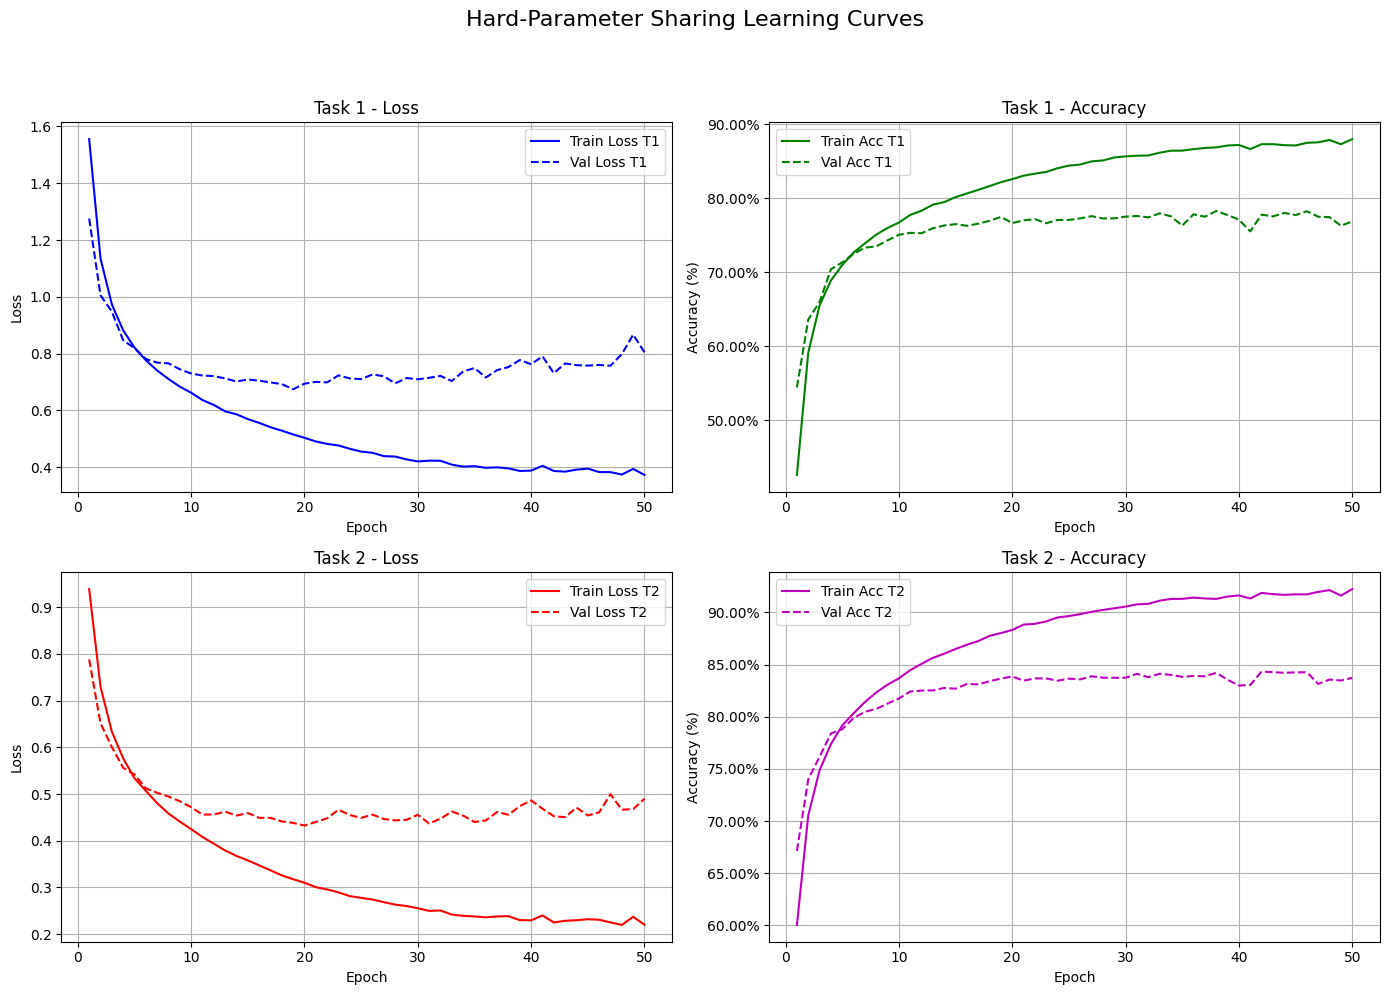

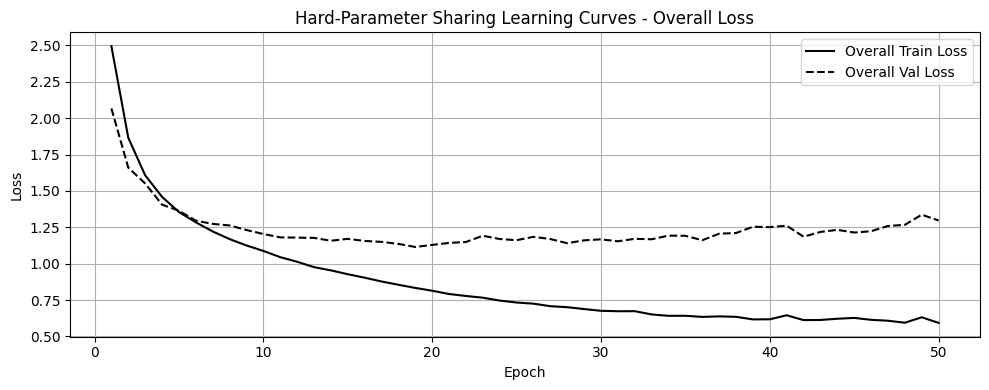

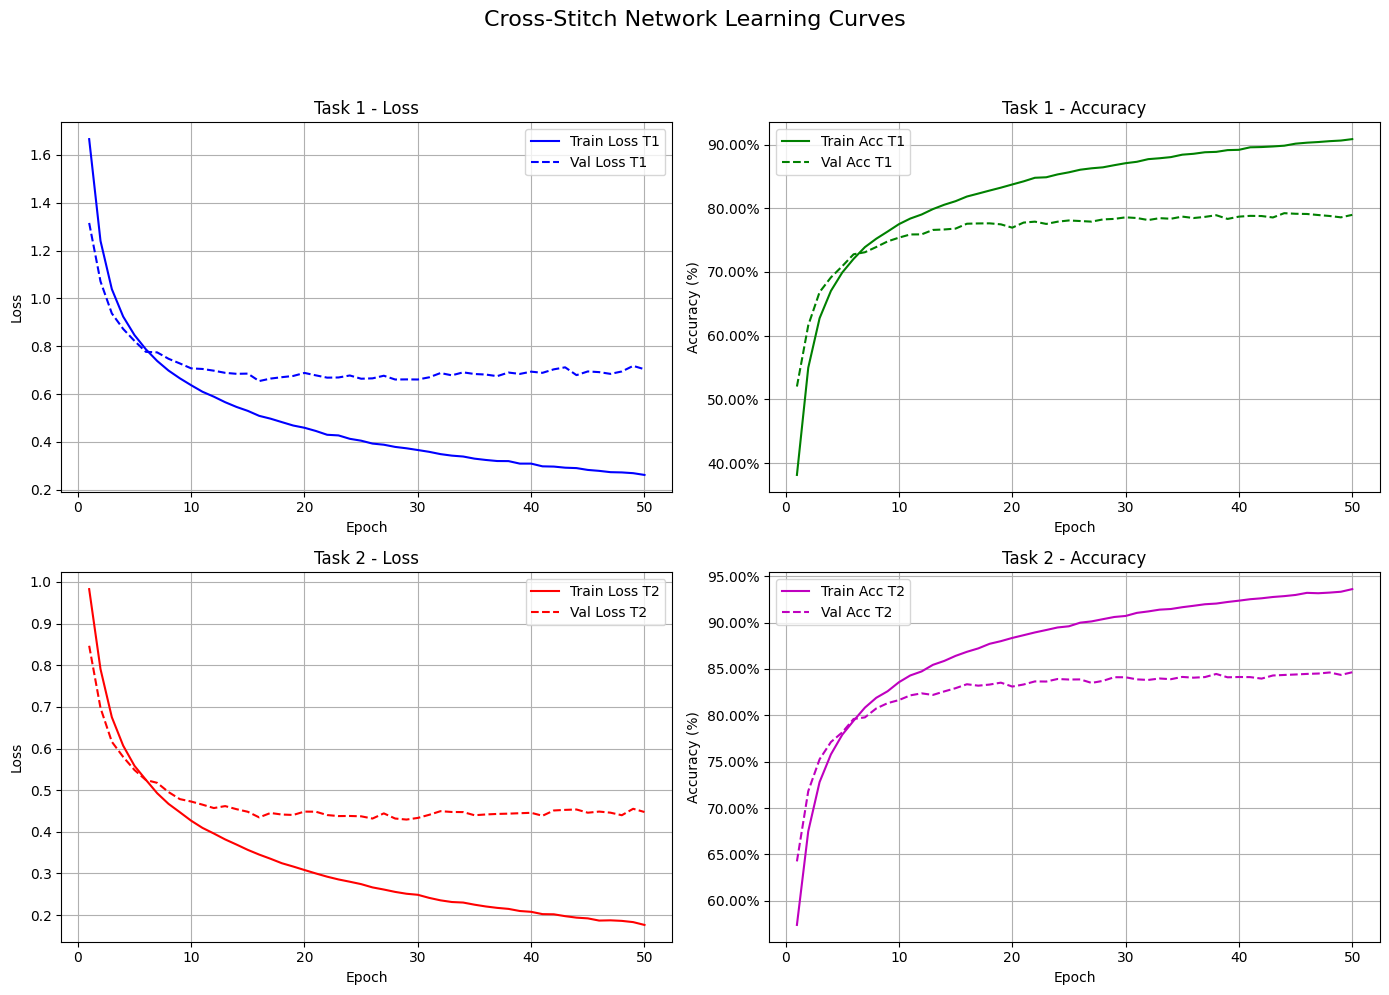

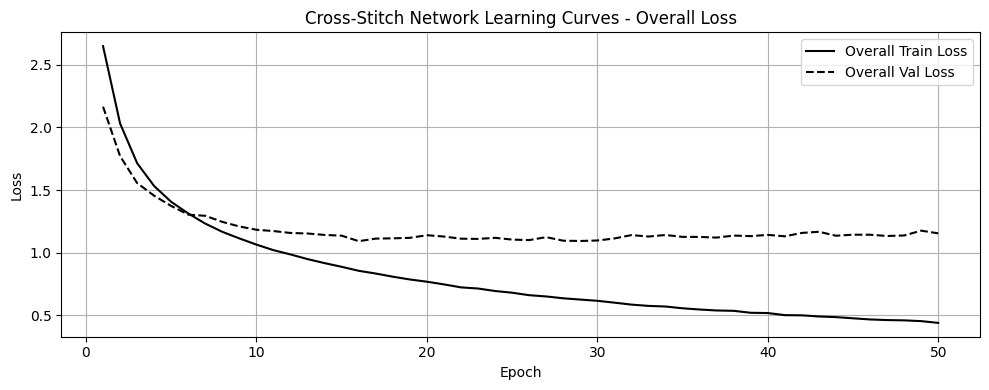

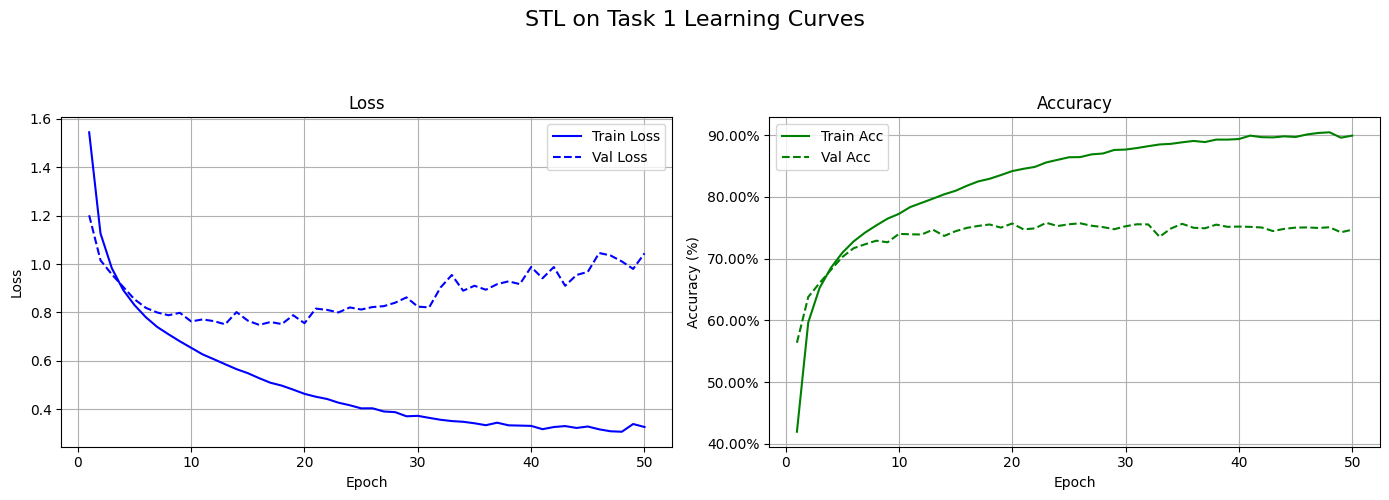

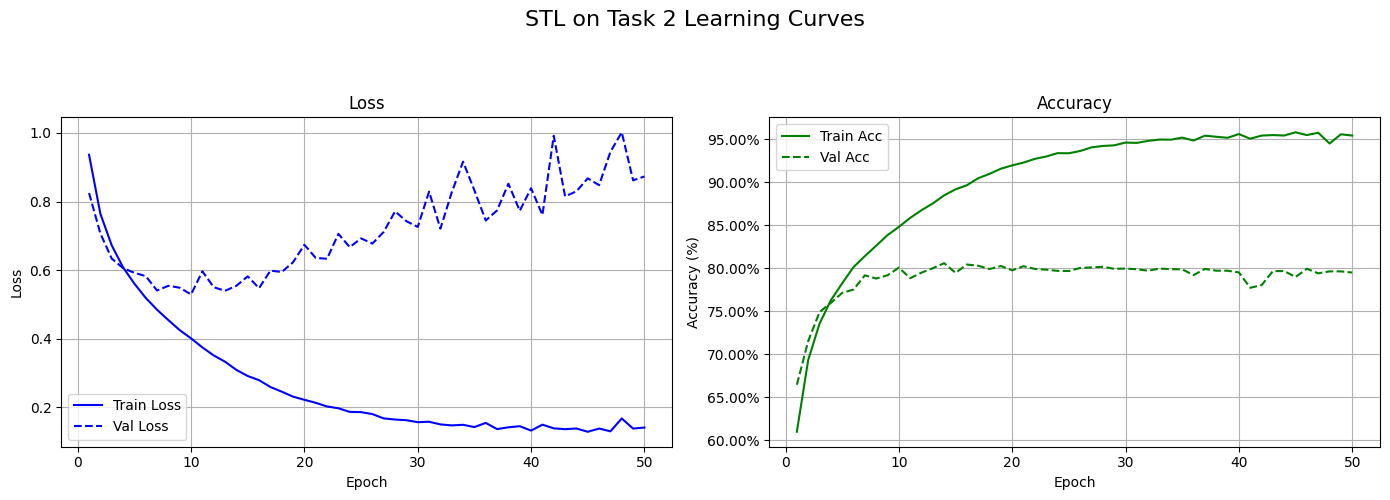

In [22]:
def plot_history(history, title, model_type):
    """Plots the training and validation history with accuracy in percentage (2 decimal places)."""
    epochs_range = range(1, NUM_EPOCHS + 1)

    formatter = mtick.FuncFormatter(lambda y, pos: f'{y:.2f}%')

    if model_type == 'mtl':
        plt.figure(figsize=(14, 10))
        plt.suptitle(title, fontsize=16, y=1.02)

        # Task 1 - Loss
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, history['train_loss_t1'], 'b-', label='Train Loss T1')
        plt.plot(epochs_range, history['val_loss_t1'], 'b--', label='Val Loss T1')
        plt.title('Task 1 - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Task 1 - Accuracy (%)
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc_t1']], 'g-', label='Train Acc T1')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc_t1']], 'g--', label='Val Acc T1')
        plt.title('Task 1 - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        # Task 2 - Loss
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history['train_loss_t2'], 'r-', label='Train Loss T2')
        plt.plot(epochs_range, history['val_loss_t2'], 'r--', label='Val Loss T2')
        plt.title('Task 2 - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Task 2 - Accuracy (%)
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc_t2']], 'm-', label='Train Acc T2')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc_t2']], 'm--', label='Val Acc T2')
        plt.title('Task 2 - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

        # Overall Loss
        plt.figure(figsize=(10, 4))
        plt.plot(epochs_range, history['train_loss'], 'k-', label='Overall Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'k--', label='Overall Val Loss')
        plt.title(f'{title} - Overall Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else: # STL
        plt.figure(figsize=(14, 5))
        plt.suptitle(title, fontsize=16, y=1.02)

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'b--', label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy (%)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc']], 'g-', label='Train Acc')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc']], 'g--', label='Val Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_history(history_hard_mtl, "Hard-Parameter Sharing Learning Curves", "mtl")
plot_history(history_cs, "Cross-Stitch Network Learning Curves", "mtl")
plot_history(history_stl_task1, "STL on Task 1 Learning Curves", "stl")
plot_history(history_stl_task2, "STL on Task 2 Learning Curves", "stl")

### 5.2. Alpha Coefficients Evolution

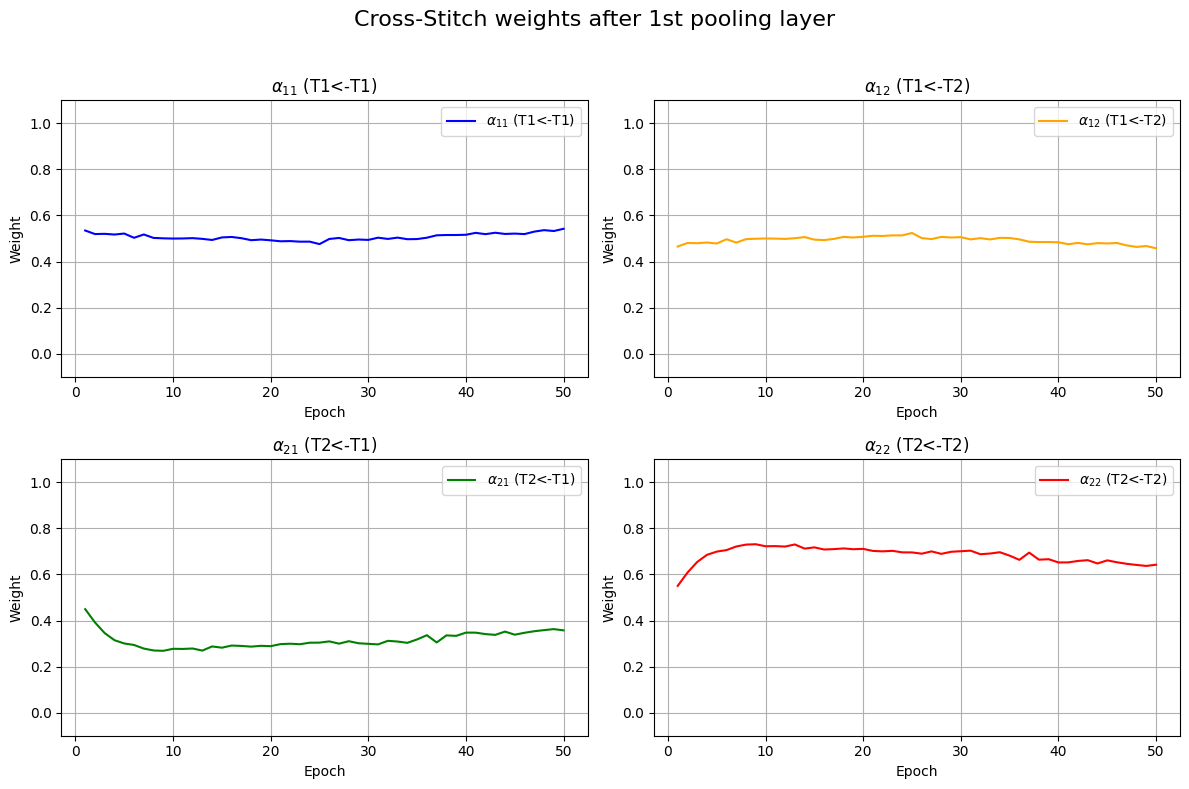

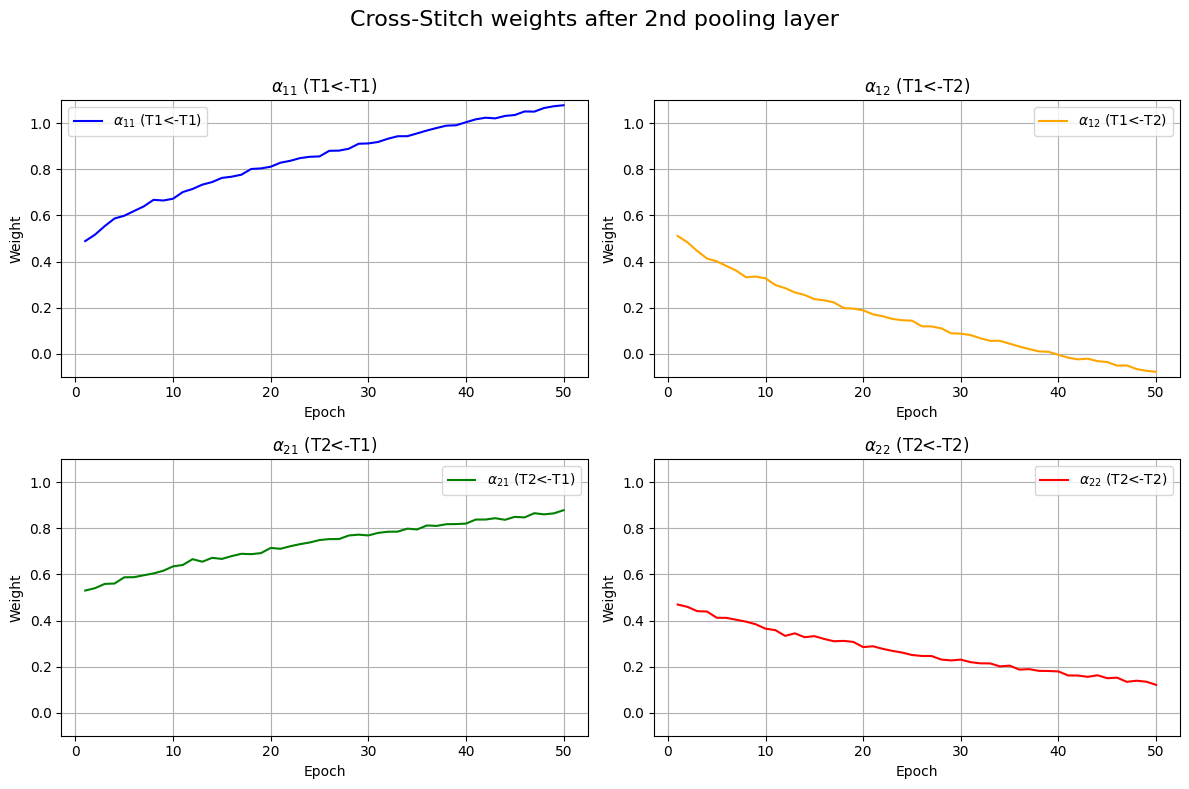

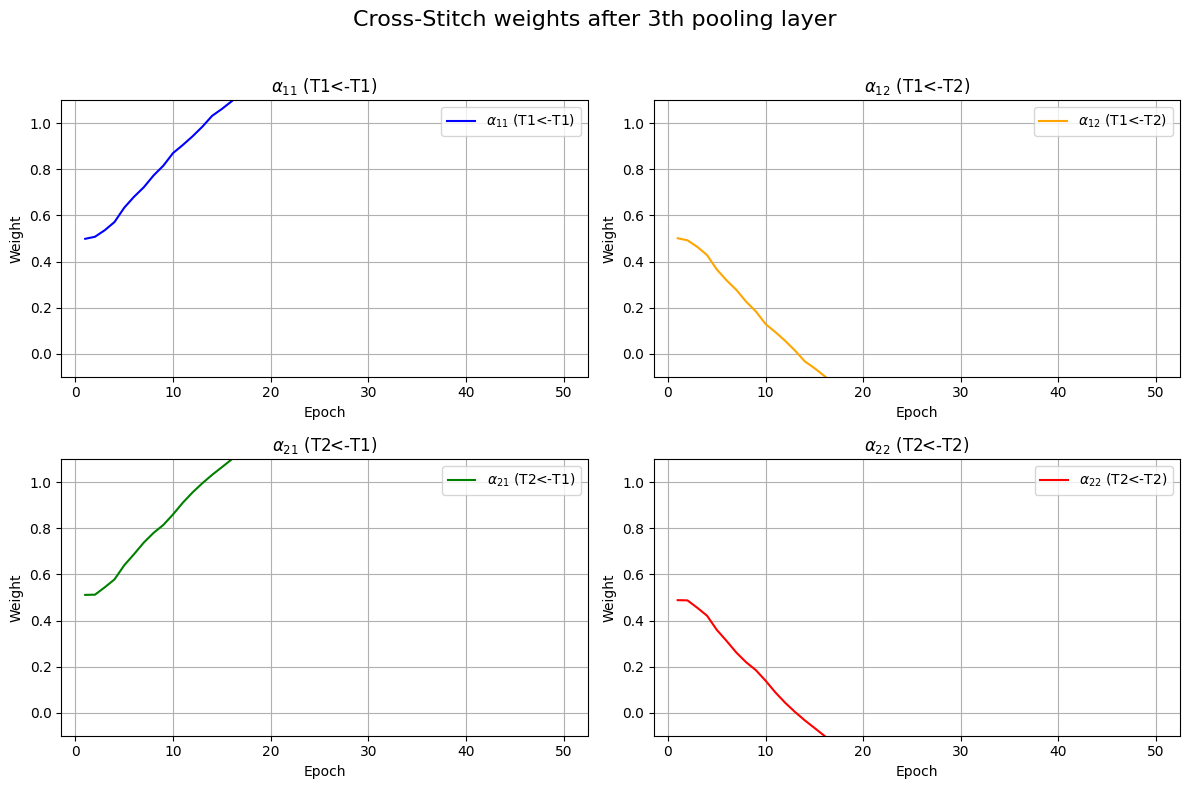

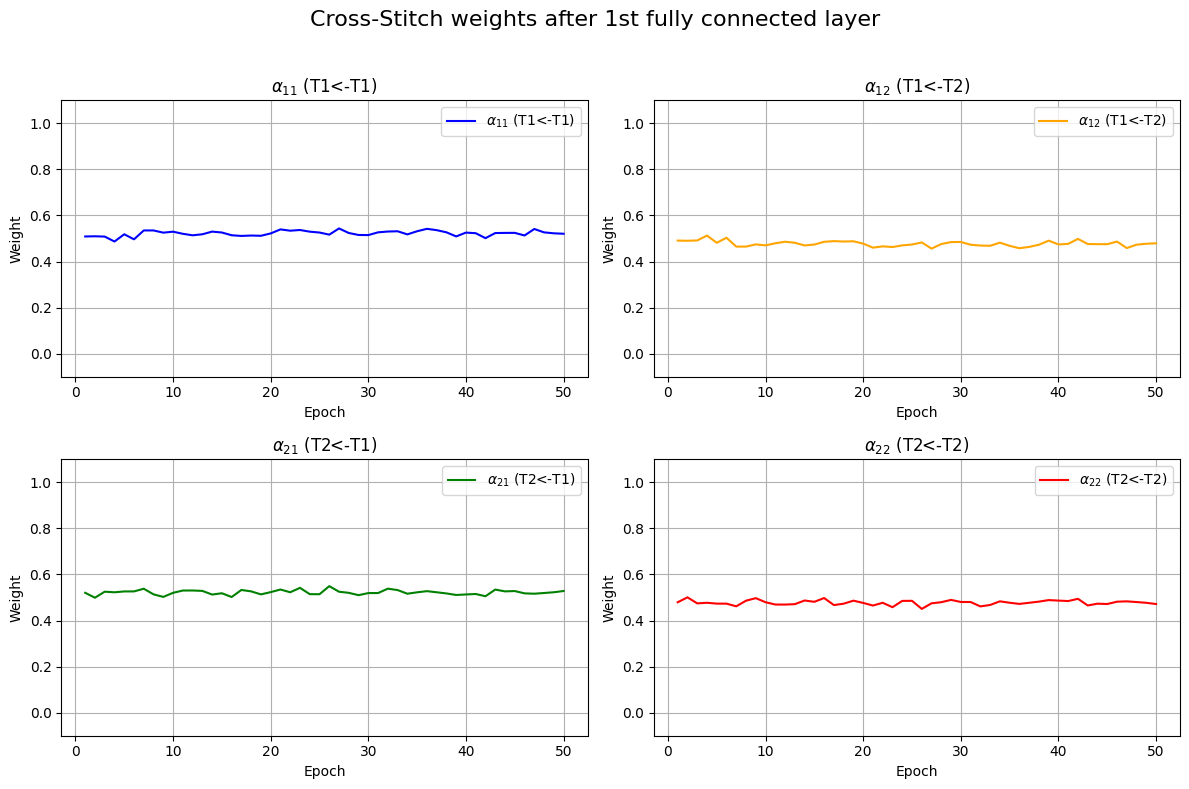

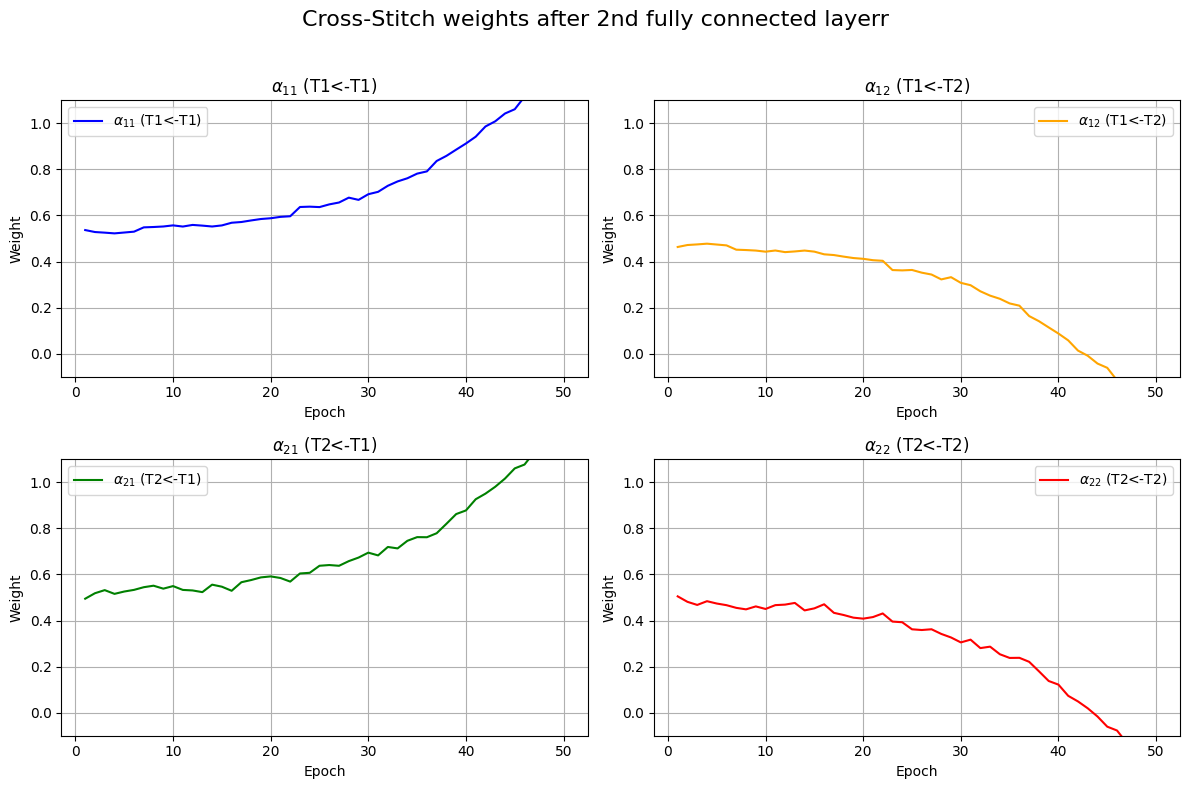

In [23]:
def plot_alpha_history(
    alpha_history_cs1,
    alpha_history_cs2,
    alpha_history_cs3,
    alpha_history_cs4,
    alpha_history_cs5,
    num_epochs):

    """Plots the evolution of alpha coefficients."""
    alphas_cs1_np = np.array(alpha_history_cs1)
    alphas_cs2_np = np.array(alpha_history_cs2)
    alphas_cs3_np = np.array(alpha_history_cs3)
    alphas_cs4_np = np.array(alpha_history_cs4)
    alphas_cs5_np = np.array(alpha_history_cs5)
    epochs_range = range(1, num_epochs + 1)

    # Plotting alpha values after pooling layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st pooling layer", fontsize=16)
    labels = [r'$\alpha_{11}$ (T1<-T1)', r'$\alpha_{12}$ (T1<-T2)', r'$\alpha_{21}$ (T2<-T1)', r'$\alpha_{22}$ (T2<-T2)']
    colors = ['blue', 'orange', 'green', 'red']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs1_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs2_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 3
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 3th pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs3_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st fully connected layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs4_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd fully connected layerr", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs5_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_alpha_history(
    alpha_history_list_cs[0],
    alpha_history_list_cs[1],
    alpha_history_list_cs[2],
    alpha_history_list_cs[3],
    alpha_history_list_cs[4],
    NUM_EPOCHS)


In [24]:
# Count the number of parameters in each model
def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print Summary Table
print(f"| Approach                  | Trainable Parameters                  |")
print(f"|-------------------------- |---------------------------------------|")
print(f"| Hard-Parameter sharing    | {count_parameters(model_hard_mtl):,}  ")
print(f"| Cross-Stitch Network      | {count_parameters(model_cs):,}        ")
print(f"| STL on Task 1             | {count_parameters(model_stl_task1):,} ")
print(f"| STL on Task 2             | {count_parameters(model_stl_task2):,} ")

| Approach                  | Trainable Parameters                  |
|-------------------------- |---------------------------------------|
| Hard-Parameter sharing    | 12,755,790  
| Cross-Stitch Network      | 15,007,394        
| STL on Task 1             | 7,506,762 
| STL on Task 2             | 7,500,612 


### 5.3. Final Evaluation on Test Set
We load the *best* saved version of each model (based on validation performance during training) and evaluate it on the test set. This gives us our final comparison metrics.

In [25]:
print("\n--- Final Evaluation on Test Set ---\n")

print("\nHard-Parameter sharing:")
# --- Load and Evaluate Hard MTL ---
model_hard_mtl.load_state_dict(torch.load('best_alexnet_hard_mtl_model.pt', map_location=device))
_, test_loss_t1_h, test_acc_t1_h, test_loss_t2_h, test_acc_t2_h = generic_evaluate_epoch_mtl(
    model_hard_mtl, test_loader, criterion, device, None, phase="Test"
)

print("\nCross-Stitch Network:\n")
# --- Load and Evaluate Cross-Stitch ---
model_cs.load_state_dict(torch.load('best_alexnet_cs_model.pt', map_location=device))
_, test_loss_t1_c, test_acc_t1_c, test_loss_t2_c, test_acc_t2_c = generic_evaluate_epoch_mtl(
    model_cs, test_loader, criterion, device, None, phase="Test"
)

print("\nSTL on Task1:\n")
# --- Load and Evaluate STL Task 1 ---
model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))
test_loss_t1_s, test_acc_t1_s = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion, device, "task1", None, phase="Test"
)

print("\nSTL on Task2:\n")
# --- Load and Evaluate STL Task 2 ---
model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))
test_loss_t2_s, test_acc_t2_s = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion, device, "task2", None, phase="Test"
)


--- Final Evaluation on Test Set ---


Hard-Parameter sharing:
Test
- Loss: 1.1149
- T1: Loss: 0.6747 - Acc: 77.50%
- T2: Loss: 0.4381 - Acc: 83.67%

Cross-Stitch Network:

Test
- Loss: 1.0915
- T1: Loss: 0.6546 - Acc: 77.57%
- T2: Loss: 0.4346 - Acc: 83.35%

STL on Task1:

Test
- Loss: 0.7485 - Acc: 74.98%

STL on Task2:

Test
- Loss: 0.5289 - Acc: 80.07%


## Conclusions

### Summary of Key Quantitative Findings

The quantitative findings presented below were obtained from a single evaluation on the test set. These results should be considered illustrative of the performance achieved in this specific experimental run, rather than a comprehensive assessment of the models' generalizable capabilities:

* **Performance on Task 1 (Object Classification):**
    * The STL model for T1 achieved an accuracy of **74.98%**.
    * Both MTL models exhibited superior performance compared to the STL baseline:
        * **Hard-Parameter Sharing** achieved **77.50%** accuracy.
        * The **Cross-Stitch Network** achieved **77.57%** accuracy, marginally outperforming the Hard-Parameter Sharing architecture.

* **Performance on Task 2 (Rotation Classification):**
    * The STL model for T2 obtained an accuracy of **80.07%**.
    * For T2, the MTL models also demonstrated notable improvements:
        * **Hard-Parameter Sharing** attained **83.67%** accuracy, slightly exceeding the Cross-Stitch Network.
        * The **Cross-Stitch Network** achieved **83.35%** accuracy.

### Analysis of Cross-Stitch $\alpha$ Coefficient Dynamics

* **Early Convolutional Layers:**
    * **Observation:** After first convolutional layer, information sharing is relatively balanced. The coefficients $\alpha_{11}$ and $\alpha_{12}$ remain close to 0.5 meaning that Task 1 equally relies on its own features and those from Task 2. Conversely, Task 2's coefficients $\alpha_{21}$ and $\alpha_{22}$ slightly deviate from 0.5, indicating a stronger reliance on its own features.
    * **Hypothesis:** Convolutional networks typically learn low-level features (edges, textures) in early layers. The balanced sharing suggests that both tasks benefit from these features, which are likely general enough to be useful for both object classification and rotation detection.

* **Deeper Convolutional Layers (2nd & 3rd):**
    * **Observation:** The observed trend dramatically changes after the 2nd and 3rd convolutional layer. The coefficients $\alpha_{11}$ and $\alpha_{21}$ (Task 1) increase towards 1.0, while $\alpha_{12}$ and $\alpha_{22}$ (Task 2) decrease towards 0. This indicates that Task 1 increasingly relies on its own features, while Task 2 begins to rely more on Task 1's features.
    * **Hypothesis:** Deeper convolutional layers capture more complex features and the $\alpha$ coefficients suggest that Task 1 is learning more specialized features for object classification and is less dependent on Task 2's features. Conversely, Task 2 appears to benefit from the richer semantic features learned by Task 1, which may be more relevant for determining object orientation.

* **Fully Connected Layers (1st and 2nd FC Layer):**
    * **Observation:** After the 1st fully connected layer, the $\alpha$ coefficients remain close to 0.5 for both tasks, indicating a balanced sharing of features extracted by the convolutional layers. However, after the 2nd fully connected layer, Task 1's coefficients $\alpha_{11}$ and $\alpha_{21}$ increase towards 1.0, while Task 2's coefficients $\alpha_{12}$ and $\alpha_{22}$ decrease towards 0.
    * **Hypothesis:** Last layers in a network are typically more task-specific. The shift in coefficients suggests that Task 1 has developed a strong set of features that are highly relevant for object classification, while Task 2 is increasingly relying on these features to determine rotation. 

### Final Considerations

While the final evaluation scores on the test set do not show a superior performance of Multi-Task Learning (MTL) approaches compared to their Single-Task Learning (STL) counterparts for these tasks, an examination of the learning curves provides critical insights into the benefits of joint learning. Specifically, these curves reveal a slight regularization effect when tasks are learned concurrently, even if, as in this instance, they are not strongly correlated. This is evidenced by the observation that STL models showed earlier and more pronounced signs of overfitting. Finally, the analysis of the $\alpha$ coefficients in the Cross-Stitch network offers a deeper understanding of the mechanisms that may contribute to this regularization. The network does not merely average features; instead, it learns an explicit and dynamic information-sharing strategy. This adaptive sharing allows the model to leverage task-specific features while still benefiting from shared representations, potentially leading to improved generalization in more complex scenarios. 